In [1]:
DATA_BASE_PATH = "/Users/mirzasharmin/Downloads/Star copy 2"

In [2]:
LOW_CUTOFF_FREQUENCY = 30
HIGH_CUTOFF_FREQUENCY = 200
ORIGINAL_FREQUENCY = 2000
TARGET_FREQUENCY = 400
SEGMENT_DURATION_SECONDS = 4

In [3]:
from src.read_data import read_all_data

patient_dfs, sinus_dfs = read_all_data(DATA_BASE_PATH)

In [4]:
first_patient_key = list(patient_dfs.keys())[0]
first_sinus_keys = list(sinus_dfs.keys())[0]

In [5]:
len(patient_dfs)

39

In [6]:
len(sinus_dfs)

5

In [7]:
from src.preprocess_data import filter_all_dataframes

filtered_patient_dfs = filter_all_dataframes(patient_dfs, LOW_CUTOFF_FREQUENCY, HIGH_CUTOFF_FREQUENCY)
filtered_sinus_dfs = filter_all_dataframes(sinus_dfs, LOW_CUTOFF_FREQUENCY, HIGH_CUTOFF_FREQUENCY)

In [8]:
from src.preprocess_data import downsample_data

downsampled_patient_dfs = downsample_data(filtered_patient_dfs, TARGET_FREQUENCY)
downsampled_sinus_dfs = downsample_data(filtered_sinus_dfs, TARGET_FREQUENCY)

In [9]:
from src.preprocess_data import normalize_data

normalized_patient_dfs = normalize_data(downsampled_patient_dfs)
normalized_sinus_dfs = normalize_data(downsampled_sinus_dfs)

In [10]:
from src.preprocess_data import segment_data

patient_segmented_arrays = segment_data(normalized_patient_dfs, segment_duration_sec=SEGMENT_DURATION_SECONDS)
sinus_segmented_arrays = segment_data(normalized_sinus_dfs, segment_duration_sec=SEGMENT_DURATION_SECONDS)

Segmenting into 4-second segments (1600 samples each)...
  /Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_30_06: 58 segments created
  /Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_31_11: 53 segments created
  /Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_32_46: 41 segments created
  /Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_33_51: 52 segments created
  /Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_34_38: 49 segments created
  /Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_35_27: 51 segments created
  /Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_36_35: 50 segments created
  /Users/mirzasharmin/Downloads/Star copy 2/Patient 10- study date 24:05:2021/2022_07_13_13_31_54: 44 segments create

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_segments(
        patient_1_segment, 
        patient_2_segment, 
        sinus_1_segment, 
        sinus_2_segment, 
        patient_1_id,
        patient_2_id, 
        sinus_1_id,
        sinus_2_id,
        electrode_number, 
        electrode_name, 
        save_path
):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Time axis (assuming 400 Hz sampling rate, 4-second segments)
    time = np.linspace(0, 4, 1600)
    
    # Plot Sinus 1 (top-left)
    axes[0, 0].plot(time, sinus_1_segment[:, electrode_number], 'b-', linewidth=1)
    axes[0, 0].set_title(f'Sinus {sinus_1_id} - Electrode {electrode_name}')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot Patient 1 (top-right)
    axes[0, 1].plot(time, patient_1_segment[:, electrode_number], 'r-', linewidth=1)
    axes[0, 1].set_title(f'Patient {patient_1_id} - Electrode {electrode_name}')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot Sinus 2 (bottom-left)
    axes[1, 0].plot(time, sinus_2_segment[:, electrode_number], 'b-', linewidth=1)
    axes[1, 0].set_title(f'Sinus {sinus_2_id} - Electrode {electrode_name}')
    axes[1, 0].set_xlabel('Time (seconds)')
    axes[1, 0].set_ylabel('Amplitude')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot Patient 2 (bottom-right)
    axes[1, 1].plot(time, patient_2_segment[:, electrode_number], 'r-', linewidth=1)
    axes[1, 1].set_title(f'Patient {patient_2_id} - Electrode {electrode_name}')
    axes[1, 1].set_xlabel('Time (seconds)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f'EGM Comparison - Electrode {electrode_name}', y=1.02, fontsize=16)
    
    plt.savefig(save_path)
    plt.show()

patient_1_segment = patient_segmented_arrays[list(patient_segmented_arrays.keys())[0]][0]
patient_2_segment = patient_segmented_arrays[list(patient_segmented_arrays.keys())[7]][0]

sinus_1_segment = sinus_segmented_arrays[list(sinus_segmented_arrays.keys())[0]][0]
sinus_2_segment = sinus_segmented_arrays[list(sinus_segmented_arrays.keys())[2]][0]

In [24]:
patient_segmented_arrays.keys()

dict_keys(['/Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_30_06', '/Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_31_11', '/Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_32_46', '/Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_33_51', '/Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_34_38', '/Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_35_27', '/Users/mirzasharmin/Downloads/Star copy 2/Patient 1- study date 21:01:2021/2022_07_11_21_36_35', '/Users/mirzasharmin/Downloads/Star copy 2/Patient 10- study date 24:05:2021/2022_07_13_13_31_54', '/Users/mirzasharmin/Downloads/Star copy 2/Patient 10- study date 24:05:2021/2022_07_13_13_33_31', '/Users/mirzasharmin/Downloads/Star copy 2/Patient 10- study date 24:05:2021/2022_07_13_13_34_44', '/User

In [25]:
sinus_segmented_arrays.keys()

dict_keys(['/Users/mirzasharmin/Downloads/Star copy 2/Patient 10- study date 24:05:2021/2022_07_13_13_38_39', '/Users/mirzasharmin/Downloads/Star copy 2/Patient 11 study date 27:05:2022 with sinus rhythm data/2022_07_13_14_03_44', '/Users/mirzasharmin/Downloads/Star copy 2/Patient 12- study date 03:08:2021 including paced recording/2022_07_17_22_50_29', '/Users/mirzasharmin/Downloads/Star copy 2/Patient 13-study date 27:09:2021 including paced rhythm/2022_07_17_12_24_42', '/Users/mirzasharmin/Downloads/Star copy 2/Patient 15-study date 25:10:2021 including recording in sinus/2022_07_17_11_32_22'])

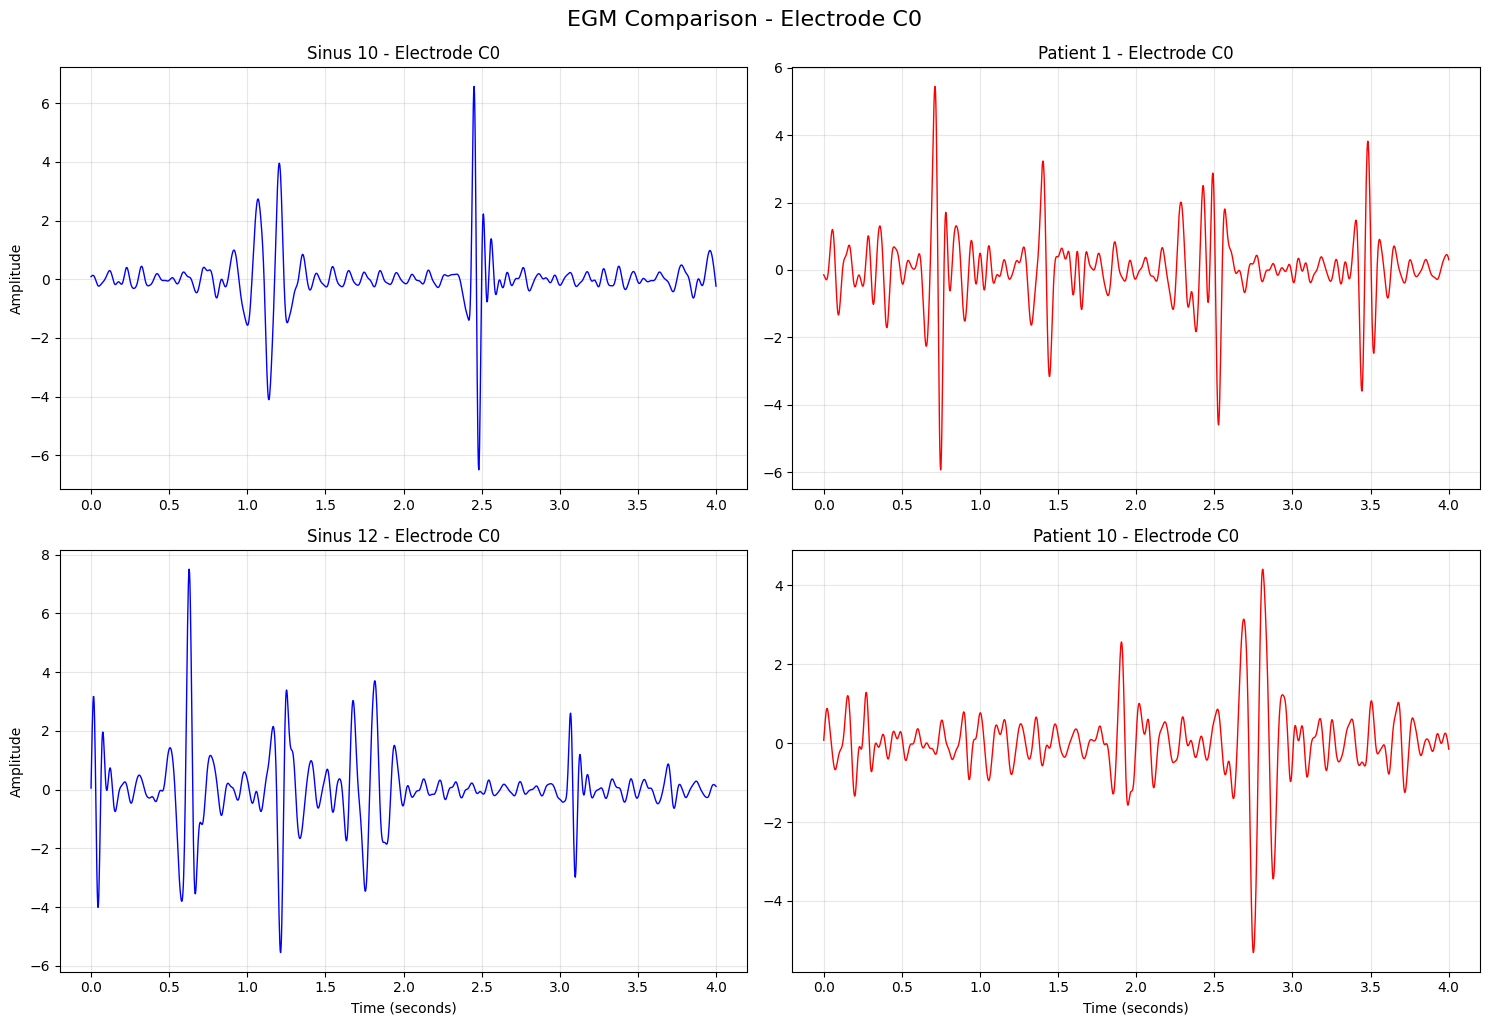

In [26]:
plot_segments(
    patient_1_segment, 
    patient_2_segment, 
    sinus_1_segment, 
    sinus_2_segment, 
    electrode_number=0, 
    electrode_name='C0',
    patient_1_id=1,
    patient_2_id=10,
    sinus_1_id=10,
    sinus_2_id=12,
    save_path='figures/segment_plot_electrode_1.png')

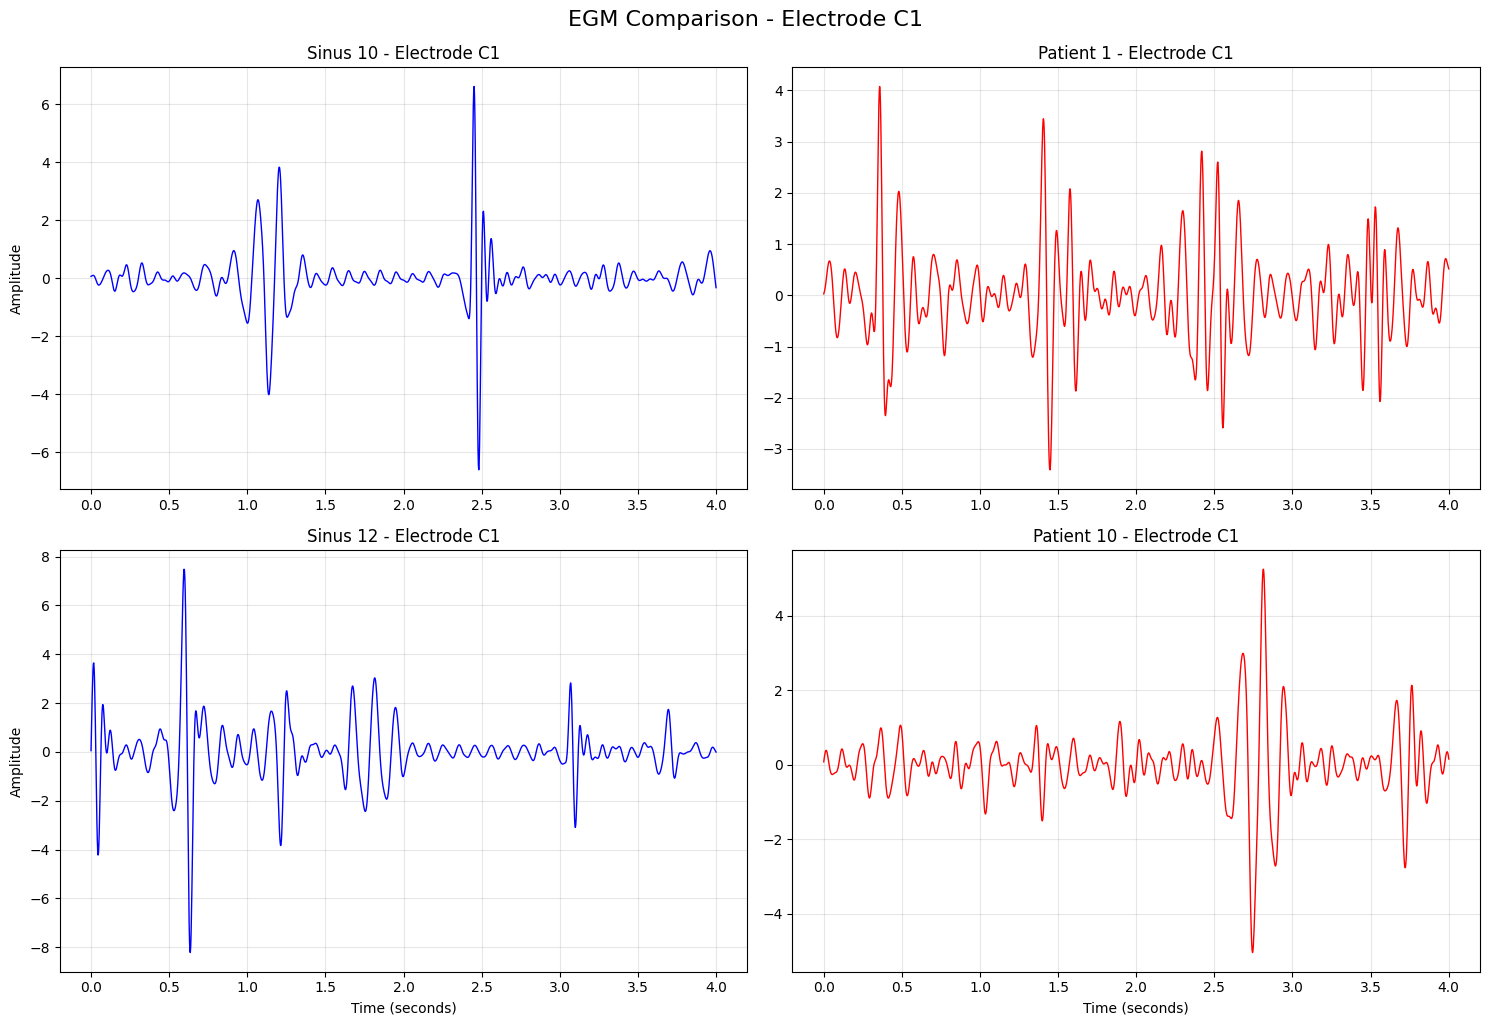

In [27]:
plot_segments(
    patient_1_segment, 
    patient_2_segment, 
    sinus_1_segment, 
    sinus_2_segment, 
    electrode_number=1, 
    electrode_name='C1',
    patient_1_id=1,
    patient_2_id=10,
    sinus_1_id=10,
    sinus_2_id=12,
    save_path='figures/segment_plot_electrode_2.png'
)

In [36]:
sinus_seg = sinus_segmented_arrays[list(sinus_segmented_arrays.keys())[0]][0]
patient_seg = patient_segmented_arrays[list(patient_segmented_arrays.keys())[0]][0]

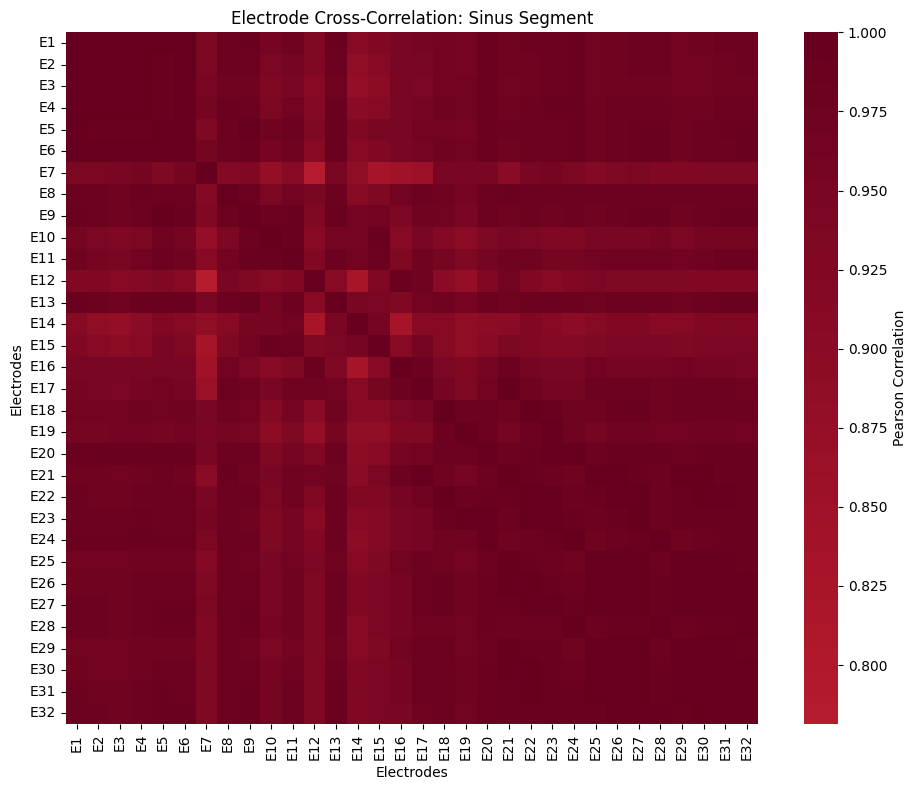

In [42]:
from src.correlation import egm_cross_correlation, print_correlation_info

sinus_correlation_matrix = egm_cross_correlation(sinus_seg, 'figures/sinus_correlation_matrix.png', 'Sinus Segment')

In [43]:
print_correlation_info(sinus_correlation_matrix)


=== Segment Correlation Analysis ===
Matrix shape: (32, 32)
Mean correlation: 0.964
Max correlation: 1.000
Min correlation: 0.781
Std deviation: 0.030

Diagonal (self-correlation): all = 1.000
Off-diagonal statistics:
  Mean: 0.963
  Max: 0.999
  Min: 0.781
  Std: 0.030

Correlation strength distribution:
  Strong positive (>0.7): 992 pairs
  Strong negative (<-0.7): 0 pairs
  Weak (|r| < 0.3): 0 pairs
  Total electrode pairs: 992

Top 5 electrode correlations:
  E26 ↔ E30: 0.999
  E27 ↔ E31: 0.999
  E25 ↔ E29: 0.999
  E30 ↔ E31: 0.999
  E26 ↔ E31: 0.998
--------------------------------------------------


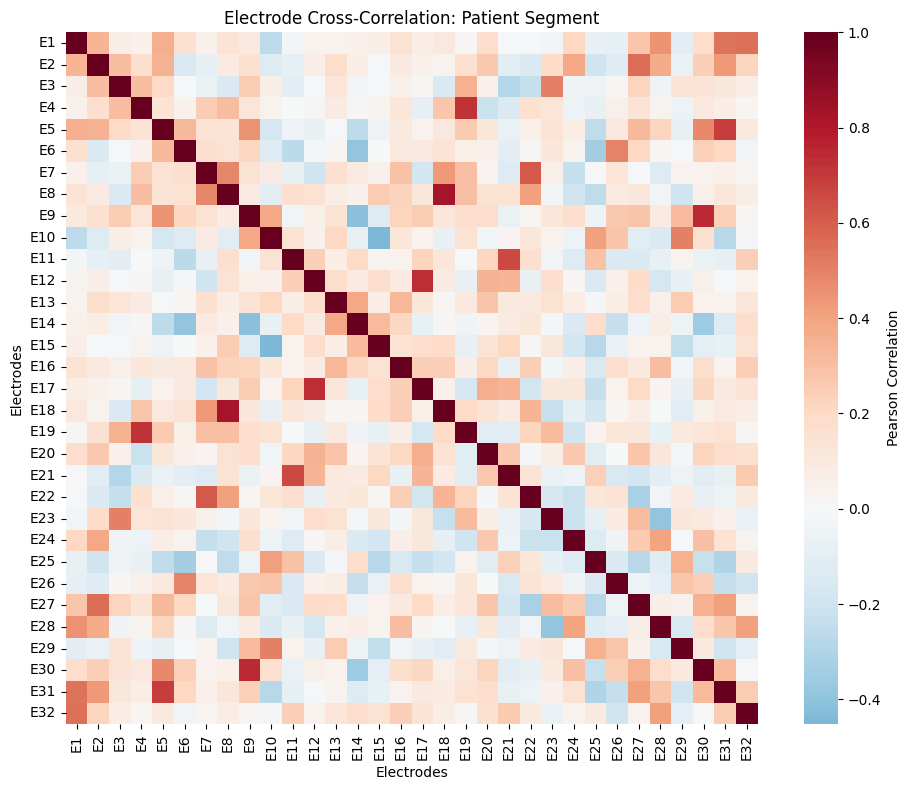

In [44]:
patient_correlation_matrix = egm_cross_correlation(patient_seg, 'figures/patient_correlation_matrix.png', 'Patient Segment')

In [45]:
print_correlation_info(patient_correlation_matrix)


=== Segment Correlation Analysis ===
Matrix shape: (32, 32)
Mean correlation: 0.104
Max correlation: 1.000
Min correlation: -0.452
Std deviation: 0.245

Diagonal (self-correlation): all = 1.000
Off-diagonal statistics:
  Mean: 0.075
  Max: 0.825
  Min: -0.452
  Std: 0.188

Correlation strength distribution:
  Strong positive (>0.7): 8 pairs
  Strong negative (<-0.7): 0 pairs
  Weak (|r| < 0.3): 872 pairs
  Total electrode pairs: 992

Top 5 electrode correlations:
  E8 ↔ E18: 0.825
  E9 ↔ E30: 0.742
  E12 ↔ E17: 0.736
  E4 ↔ E19: 0.722
  E5 ↔ E31: 0.692
--------------------------------------------------


In [ ]:
sum([len(segments) for key, segments in patient_segmented_arrays.items()])

In [ ]:
sum([len(segments) for key, segments in sinus_segmented_arrays.items()])

In [ ]:
from src.dataset import prepare_data

train_data, valid_data, test_data, train_labels, valid_labels, test_labels = prepare_data(patient_segmented_arrays, sinus_segmented_arrays)

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
from src.training import run_training_pipeline
from src.training import predict_and_evaluate

model_with_smote, history_with_smote = run_training_pipeline(
    train_data, train_labels, valid_data, valid_labels, model_type="transformer", device=device, use_smote=True
)

In [ ]:
model_without_smote, history_without_smote = run_training_pipeline(
    train_data, train_labels, valid_data, valid_labels, model_type="transformer", device=device , use_smote=False
)

In [ ]:
import pickle

with open('save/history_without_smote_transformer.pkl', 'wb') as file:
    pickle.dump(history_without_smote, file)
    
with open('save/history_with_smote_transformer.pkl', 'wb') as file:
    pickle.dump(history_with_smote, file)

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot losses
ax1.plot(history_without_smote
         ['train_losses'], label='Train Loss', color='blue')
ax1.plot(history_without_smote['test_losses'], label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracies
ax2.plot(history_without_smote['train_accuracies'], label='Train Accuracy', color='blue')
ax2.plot(history_without_smote['test_accuracies'], label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/loss_curves_without_smote_transformer.png')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot losses
ax1.plot(history_with_smote
         ['train_losses'], label='Train Loss', color='blue')
ax1.plot(history_with_smote['test_losses'], label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracies
ax2.plot(history_with_smote['train_accuracies'], label='Train Accuracy', color='blue')
ax2.plot(history_with_smote['test_accuracies'], label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/loss_curves_with_smote_transformer.png')
plt.show()

In [ ]:
print("=== Results with SMOTE ===")
results_smote = predict_and_evaluate(model_with_smote, test_data, test_labels)

print("\n=== Results without SMOTE ===") 
results_no_smote = predict_and_evaluate(model_without_smote, test_data, test_labels)

print(f"\nComparison:")
print(f"SMOTE F1-Score: {results_smote['f1_score']:.3f}")
print(f"No SMOTE F1-Score: {results_no_smote['f1_score']:.3f}")

In [ ]:
import torch

torch.save(model_without_smote.state_dict(), 'save/model_without_smote_transformer.pth')
torch.save(model_with_smote.state_dict(), 'save/model_with_smote_transformer.pth')

In [ ]:
from src.training import predict_and_evaluate

test_results_without_smote = predict_and_evaluate(model_without_smote, test_data, test_labels, device)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics from results dictionary
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [test_results_without_smote['accuracy'], test_results_without_smote['precision'], test_results_without_smote['recall'], test_results_without_smote['f1_score']]

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#2E86AB', '#A23B72', '#F18F01'], alpha=0.8, edgecolor='black', linewidth=1.2)

# Customize the plot
plt.title('Model Performance Metrics (without SMOTE)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.0)  # Set y-axis from 0 to 1

# Add value labels on top of bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add horizontal grid lines
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Customize appearance
plt.tight_layout()
plt.savefig('figures/model_performance_without_smote_transformer.png')
plt.show()

In [ ]:
test_results_with_smote = predict_and_evaluate(model_with_smote, test_data, test_labels, device)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics from results dictionary
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [test_results_with_smote['accuracy'], test_results_with_smote['precision'], test_results_with_smote['recall'], test_results_with_smote['f1_score']]

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#2E86AB', '#A23B72', '#F18F01'], alpha=0.8, edgecolor='black', linewidth=1.2)

# Customize the plot
plt.title('Model Performance Metrics (With SMOTE)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.0)  # Set y-axis from 0 to 1

# Add value labels on top of bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add horizontal grid lines
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Customize appearance
plt.tight_layout()
plt.savefig('figures/model_performance_with_smote_transformer.png')
plt.show()